**Downloading and Cleaning Meterological Data** <br>
Carolyn Vilter <br>
<br>
Inspiration / Meteorological API approach from Varsha Gopalakrishnan<br>
https://github.com/varsha2509/hyperlocal-aq-prediction/blob/master/Notebooks/Daymet-Data-API-Call.ipynb

In [6]:
# Setup
import daymetpy
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np

## Met data for training

In [7]:
# Basis of eventual met dataset: Vishal's air quality sensor data
# Air quality sensors will be the rows/obs of the final dataset

air_quality_NO2 = pd.read_csv("../../data/cleaned/air_quality_NO2.csv")
air_quality_NO2

,Unnamed: 0,locationId,location,city,country,utc,local,parameter,value,unit,latitude,longitude
0,0,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000517,ppm,29.789446,-95.483822
1,1,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000756,ppm,29.750588,-95.419853
2,2,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.001427,ppm,29.810590,-95.348540
3,3,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.001262,ppm,29.786917,-95.298818
4,4,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000803,ppm,29.604903,-95.364682
...,...,...,...,...,...,...,...,...,...,...,...,...
11529,11529,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000631,ppm,29.806077,-95.393692
11530,11530,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000593,ppm,29.735933,-95.235322
11531,11531,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.001280,ppm,29.770637,-95.397326
11532,11532,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.001794,ppm,29.801806,-95.341444


In [8]:
# FIRST: tf_no2 data
# Create lat and lon rounded to 2 dp - the sensitivity of the met data API
air_quality_NO2["lat_short"] = air_quality_NO2["latitude"].round(2)
air_quality_NO2["lon_short"] = air_quality_NO2["longitude"].round(2)

# Create a unique list of lat, long pairs rounded to 2 decimal places
# These are the points we need meteorological data for 
air_quality_NO2_short = air_quality_NO2[["lat_short", "lon_short"]]
air_quality_NO2_short.drop_duplicates(inplace = True)
air_quality_NO2_short

/var/folders/w0/hp1p0mz546x0rnc9mft_s83w0000gn/T/ipykernel_58500/4108640535.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality_NO2_short.drop_duplicates(inplace = True)


,lat_short,lon_short
0,29.79,-95.48
1,29.75,-95.42
2,29.81,-95.35
3,29.79,-95.30
4,29.60,-95.36
...,...,...
3673,29.77,-95.26
3987,29.78,-95.46
4610,29.79,-95.49
5027,29.62,-95.36


In [ ]:
met_data = None
for index, row in air_quality_NO2_short.iterrows():
    lat = row["lat_short"]
    lon = row["lon_short"]
    # for each lat, lon pair in the list, get 2017-2018 data
    data = daymetpy.daymet_timeseries(lon=lon, lat=lat, start_year=2017, end_year=2018)
    # then limit to the time range (July 2017 to March 2018, inclusive)
    data = data[((data["yday"] >= 182) & (data["year"] == 2017)) | ((data["yday"] <= 90) & (data["year"] == 2018))]
    # then compress to one row containing the average of each var for all observations
    # removing unnecessary variables
    data = data.mean(axis=0).to_frame().transpose().drop(["year", "dayl", "yday"], axis=1)
    # then add lat lon columns
    data["lat_short"] = lat
    data["lon_short"] = lon
    # then append the new row to the main df
    if index == 0:
        met_data = data
    else:
        met_data = pd.concat([met_data, data])


In [ ]:
met_data

,prcp,srad,swe,tmax,tmin,vp,lat_short,lon_short
0,6.013942,324.280839,0.0,26.028285,15.117482,1923.620985,29.79,-95.48
0,6.062372,324.512628,0.0,26.011606,15.253796,1939.266788,29.75,-95.42
0,6.364124,323.496971,0.0,25.941131,15.169124,1930.899416,29.81,-95.35
0,6.543102,322.899088,0.0,25.879489,15.221825,1936.849307,29.79,-95.30
0,5.763905,325.528248,0.0,25.994635,15.577007,1976.188212,29.60,-95.36
...,...,...,...,...,...,...,...,...
0,6.648504,321.606569,0.0,25.818942,15.266934,1941.546131,29.77,-95.26
0,6.026204,324.602007,0.0,26.029562,15.162263,1928.930474,29.78,-95.46
0,6.008905,324.609124,0.0,26.041423,15.112956,1922.943285,29.79,-95.49
0,5.852336,325.209818,0.0,25.986642,15.545073,1972.396423,29.62,-95.36


In [ ]:
# then join the new, main met df onto vishal's data
no2_met = pd.merge(air_quality_NO2, met_data, on = ["lat_short", "lon_short"])
no2_met.drop(["Unnamed: 0", "locationId", "location", "city", "country", "utc", "local", "parameter", "value", "unit", "lat_short", "lon_short", "swe"], axis = 1, inplace = True)
no2_met

,latitude,longitude,prcp,srad,tmax,tmin,vp
0,29.789446,-95.483822,6.013942,324.280839,26.028285,15.117482,1923.620985
1,29.791588,-95.481751,6.013942,324.280839,26.028285,15.117482,1923.620985
2,29.789405,-95.483061,6.013942,324.280839,26.028285,15.117482,1923.620985
3,29.794780,-95.477146,6.013942,324.280839,26.028285,15.117482,1923.620985
4,29.792618,-95.480138,6.013942,324.280839,26.028285,15.117482,1923.620985
...,...,...,...,...,...,...,...
11529,29.615010,-95.355268,5.852336,325.209818,25.986642,15.545073,1972.396423
11530,29.615940,-95.355437,5.852336,325.209818,25.986642,15.545073,1972.396423
11531,29.616374,-95.355169,5.852336,325.209818,25.986642,15.545073,1972.396423
11532,29.616391,-95.355433,5.852336,325.209818,25.986642,15.545073,1972.396423


In [ ]:
# Export
filepath = "/Users/carolynvilter/Documents/MSCAPP_Y1Q3/machine_learning/air-quality-prediction/data/cleaned/no2_met.csv"
no2_met.to_csv(filepath)

Avg Daily Precipitation


count    11534.000000
mean         6.161217
std          0.310194
min          5.670803
25%          5.942007
50%          6.202847
75%          6.437336
max          6.779051
Name: prcp, dtype: float64

<AxesSubplot:>

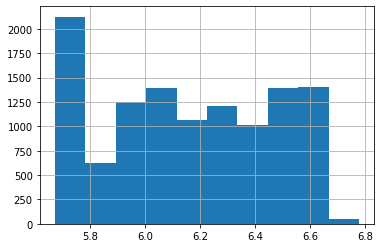

In [ ]:
# Precipitation: 
# Descriptive stats
print("Avg Daily Precipitation")
display(no2_met.describe()['prcp'])
# Histogram
no2_met['prcp'].hist()

Avg Daily Maximum Temperature


count    11534.000000
mean        25.975586
std          0.101141
min         25.749343
25%         25.877482
50%         25.983613
75%         26.040912
max         26.146715
Name: tmax, dtype: float64

Avg Daily Minimum Temperature


count    11534.000000
mean        15.313404
std          0.131956
min         15.095985
25%         15.228723
50%         15.283431
75%         15.369088
max         15.622591
Name: tmin, dtype: float64

<AxesSubplot:>

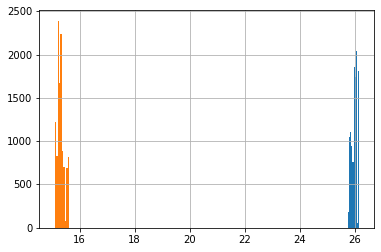

In [ ]:
# Temperature: 
# Descriptive stats
## tmax
print("Avg Daily Maximum Temperature")
display(no2_met.describe()['tmax'])
## tmin
print("Avg Daily Minimum Temperature")
display(no2_met.describe()['tmin'])
# Histogram: tmax and tmin
no2_met['tmax'].hist()
no2_met['tmin'].hist()

## Met data for prediction

In [20]:
predict_NO2 = pd.read_csv("../../data/cleaned/predict.csv")
predict_NO2

,Unnamed: 0,lat,lon
0,0,29.672427,-95.319700
1,1,29.672427,-95.322203
2,2,29.672427,-95.324705
3,3,29.672427,-95.327208
4,4,29.672427,-95.329710
...,...,...,...
217,97,29.763409,-95.516346
218,98,29.763409,-95.518844
219,99,29.763409,-95.521342
220,100,29.763409,-95.523840


In [34]:
# FIRST: tf_no2 data
# Create lat and lon rounded to 2 dp - the sensitivity of the met data API
predict_NO2["lat_short"] = predict_NO2["lat"].round(2)
predict_NO2["lon_short"] = predict_NO2["lon"].round(2)

# Create a unique list of lat, long pairs rounded to 2 decimal places
# These are the points we need meteorological data for 
predict_NO2_short = predict_NO2[["lat_short", "lon_short"]]
predict_NO2_short.drop_duplicates(inplace = True)
print(len(predict_NO2_short))
predict_NO2_short

28


/var/folders/w0/hp1p0mz546x0rnc9mft_s83w0000gn/T/ipykernel_58500/4257753275.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_NO2_short.drop_duplicates(inplace = True)


,lat_short,lon_short
0,29.67,-95.32
3,29.67,-95.33
7,29.67,-95.34
11,29.67,-95.35
15,29.67,-95.36
19,29.67,-95.37
20,29.68,-95.32
23,29.68,-95.33
27,29.68,-95.34
31,29.68,-95.35


In [22]:
# Get met data from API for these unique 2-decimal-place lat/long pairs (prediction grid)
met_predict = None
for index, row in predict_NO2_short.iterrows():
    lat = row["lat_short"]
    lon = row["lon_short"]
    # for each lat, lon pair in the list, get 2017-2018 data
    data = daymetpy.daymet_timeseries(lon=lon, lat=lat, start_year=2017, end_year=2018)
    # then limit to the time range (July 2017 to March 2018, inclusive)
    data = data[((data["yday"] >= 182) & (data["year"] == 2017)) | ((data["yday"] <= 90) & (data["year"] == 2018))]
    # then compress to one row containing the average of each var for all observations
    # removing unnecessary variables
    data = data.mean(axis=0).to_frame().transpose().drop(["year", "dayl", "yday"], axis=1)
    # then add lat lon columns
    data["lat_short"] = lat
    data["lon_short"] = lon
    # then append the new row to the main df
    if index == 0:
        met_predict = data
    else:
        met_predict = pd.concat([met_predict, data])

In [33]:
print(len(met_predict))
met_predict

28


,prcp,srad,swe,tmax,tmin,vp,lat_short,lon_short
0,6.244562,323.776058,0.0,25.944891,15.494343,1967.616314,29.67,-95.32
0,6.217628,323.016971,0.0,25.949672,15.481314,1965.948102,29.67,-95.33
0,6.173321,323.238175,0.0,25.968832,15.477993,1965.452372,29.67,-95.34
0,6.146898,323.210547,0.0,25.987737,15.474015,1964.922555,29.67,-95.35
0,6.082226,323.118869,0.0,25.998066,15.464745,1963.732591,29.67,-95.36
0,6.028029,324.230146,0.0,26.008394,15.455584,1962.489562,29.67,-95.37
0,6.254380,323.194380,0.0,25.938467,15.470985,1964.833467,29.68,-95.32
0,6.236642,322.267299,0.0,25.949891,15.462701,1963.793832,29.68,-95.33
0,6.224964,322.254781,0.0,25.961350,15.454015,1962.688102,29.68,-95.34
0,6.155620,322.495912,0.0,25.980255,15.450511,1962.190000,29.68,-95.35


In [37]:
# Then join the new, main met df onto prediction grid data
met_data_predict = pd.merge(predict_NO2, met_predict, on = ["lat_short", "lon_short"])
met_data_predict.drop(["Unnamed: 0", "lat_short", "lon_short", "swe"], axis = 1, inplace = True)
met_data_predict

,lat,lon,prcp,srad,tmax,tmin,vp
0,29.672427,-95.319700,6.244562,323.776058,25.944891,15.494343,1967.616314
1,29.672427,-95.322203,6.244562,323.776058,25.944891,15.494343,1967.616314
2,29.672427,-95.324705,6.244562,323.776058,25.944891,15.494343,1967.616314
3,29.672427,-95.327208,6.217628,323.016971,25.949672,15.481314,1965.948102
4,29.672427,-95.329710,6.217628,323.016971,25.949672,15.481314,1965.948102
...,...,...,...,...,...,...,...
217,29.763409,-95.523840,5.889672,325.577737,26.045109,15.117883,1922.566971
218,29.755712,-95.526338,5.857044,325.942664,26.060803,15.125693,1923.030182
219,29.758277,-95.526338,5.857044,325.942664,26.060803,15.125693,1923.030182
220,29.760843,-95.526338,5.857044,325.942664,26.060803,15.125693,1923.030182


Avg Daily Precipitation


count    222.000000
mean       6.050214
std        0.152751
min        5.806314
25%        5.902117
50%        6.097755
75%        6.217628
max        6.289562
Name: prcp, dtype: float64

<AxesSubplot:>

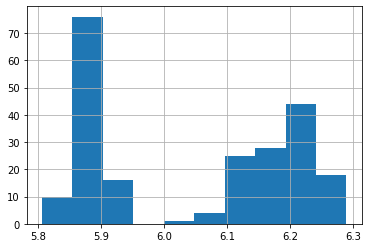

In [39]:
# Precipitation: 
# Descriptive stats
print("Avg Daily Precipitation")
display(met_data_predict.describe()['prcp'])
# Histogram
met_data_predict['prcp'].hist()

Avg Daily Maximum Temperature


count    222.000000
mean      26.022048
std        0.060267
min       25.931423
25%       25.961350
50%       26.000912
75%       26.089808
max       26.100620
Name: tmax, dtype: float64

Avg Daily Minimum Temperature


count    222.000000
mean      15.324145
std        0.145429
min       15.117883
25%       15.177664
50%       15.434891
75%       15.454015
max       15.494343
Name: tmin, dtype: float64

<AxesSubplot:>

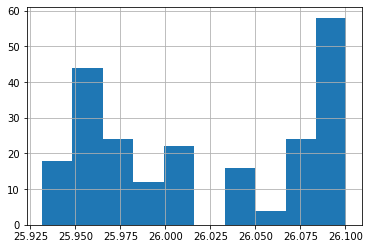

In [41]:
# Temperature: 
# Descriptive stats
## tmax
print("Avg Daily Maximum Temperature")
display(met_data_predict.describe()['tmax'])
## tmin
print("Avg Daily Minimum Temperature")
display(met_data_predict.describe()['tmin'])
# Histogram: tmax and tmin
met_data_predict['tmax'].hist()

<AxesSubplot:>

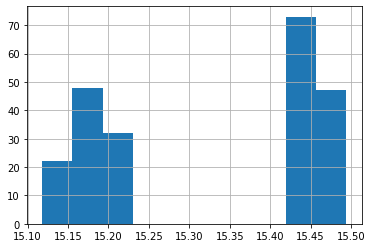

In [42]:
met_data_predict['tmin'].hist()

In [43]:
# Export prediction no2 lat/lons with met data 
filepath = "../../data/cleaned/met_data_predict.csv"
met_data_predict.to_csv(filepath)